# **Introduction**

This dataset was acquired from an RTO (regional transmission organization) called PJM Interconnection LLC. Regional transmission organizations control and coordinate multi-state grids that span across state borders. They were created to promote energy efficiency, reliability, and non-discriminatory practices. The introduction of RTOs largely changed the economic landscape of some states as before their creation individual states had a monopoly on the generation and distribution of electricity within their state. 

PJM Interconnection LLC is responsible for the eastern states like Delaware, Illinois, Indiana, Kentucky, etc. The consumption data is displayed in MW.

In the notebook below I will perform an exploratory data analysis and build a time series prediction model using the XGBoost machine learning algorithm. My main goal is to find some interesting insights and correlations between the time and consumption data.

# **Importing libraries**

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

#from bokeh.plotting import figure, show, output_notebook
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

plt.style.use("ggplot") # Set plot style
%matplotlib inline

# **Importing the dataset**

In [3]:
df = pd.read_csv(r"AEP_hourly.csv")



The feature engineering part was split into two for practical purposes. Part one contains features that were diverted from the DateTime column without too much data manipulation.

In [4]:
df["Datetime"] = pd.to_datetime(df["Datetime"])

#Date features
df["Hour"] = df["Datetime"].dt.hour
df["Day"] = df["Datetime"].dt.dayofweek
df["Month"] = df["Datetime"].dt.month
df["Year"] = df["Datetime"].dt.year
df["Q"] = df["Datetime"].dt.quarter
df["Dayofyear"] = df["Datetime"].dt.dayofyear
df["Dayofmonth"] = df["Datetime"].dt.day
df["Weekofyear"] = df["Datetime"].dt.weekofyear

df["Drop_me"] = df["Datetime"].dt.strftime("%m-%d")

df.index = df["Datetime"]
df = df.drop(["Datetime"],axis=1)

C:\Users\Dell\AppData\Local\Temp/ipykernel_14180/3486507697.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["Weekofyear"] = df["Datetime"].dt.weekofyear


# **Initial look**

We are going to take a closer look at the dataset and highlight some interesting patterns in the consumption data.

In [5]:
df.head()


,AEP_MW,Hour,Day,Month,Year,Q,Dayofyear,Dayofmonth,Weekofyear,Drop_me
Datetime,,,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,12,2004,4,366,31,53,12-31
2004-12-31 02:00:00,12865.0,2,4,12,2004,4,366,31,53,12-31
2004-12-31 03:00:00,12577.0,3,4,12,2004,4,366,31,53,12-31
2004-12-31 04:00:00,12517.0,4,4,12,2004,4,366,31,53,12-31
2004-12-31 05:00:00,12670.0,5,4,12,2004,4,366,31,53,12-31


Text(0.0, 1.0, 'Consumption distribution')

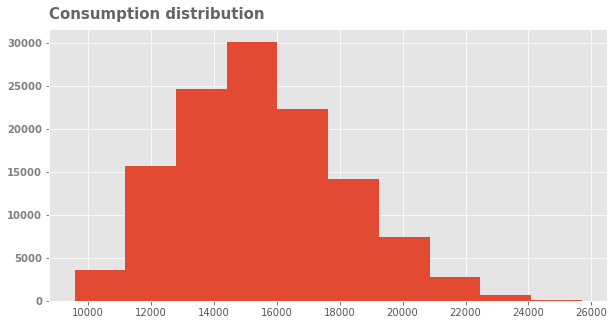

In [6]:
ax, fig = plt.subplots(figsize=(10,5))

plt.hist(df["AEP_MW"])

plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("",alpha=0.75, weight="bold")
plt.ylabel("",alpha=0.75, weight="bold")

plt.title("Consumption distribution", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10)

The distribution plot is slightly left-skewed, with the majority of the consumption moving around the 30-35k range.

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

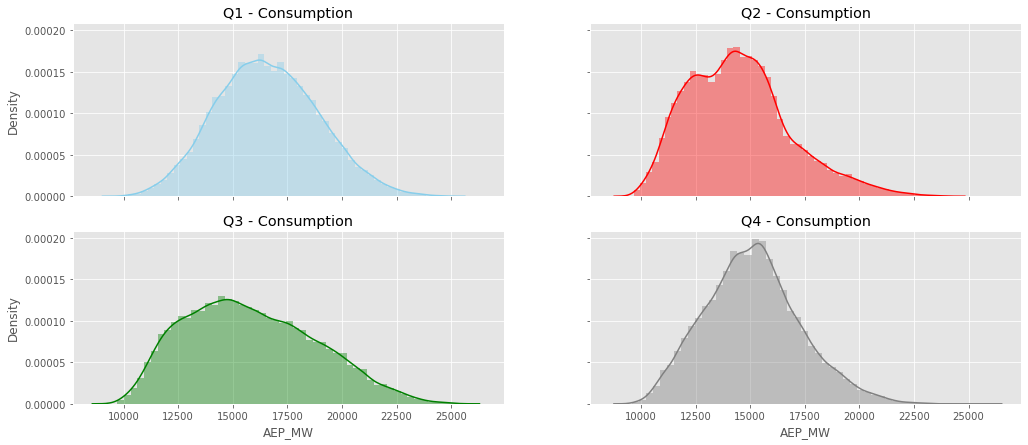

In [7]:
#Data prep
Q1 = df[df["Q"]==1]
Q2 = df[df["Q"]==2]
Q3 = df[df["Q"]==3]
Q4 = df[df["Q"]==4]

#Plot
fig,axes = plt.subplots(2,2,figsize=(17,7),sharex=True,sharey=True)

sns.distplot(Q1["AEP_MW"],color="skyblue", ax=axes[0,0]).set_title("Q1 - Consumption")
sns.distplot(Q2["AEP_MW"],color="red", ax=axes[0,1]).set_title("Q2 - Consumption")
sns.distplot(Q3["AEP_MW"],color="green", ax=axes[1,0]).set_title("Q3 - Consumption")
sns.distplot(Q4["AEP_MW"],color="gray", ax=axes[1,1]).set_title("Q4 - Consumption")

del Q1, Q2, Q3, Q4

There are some major differences in the consumption distribution per quarter. This might be due to several factors, the most obvious being seasonal demand changes. Another major factor is the general temperature in the area. Higher temperatures encourage more electricity usage as office buildings and homes require cooling.

Text(0.0, 1.0, 'Mean daily consumption')

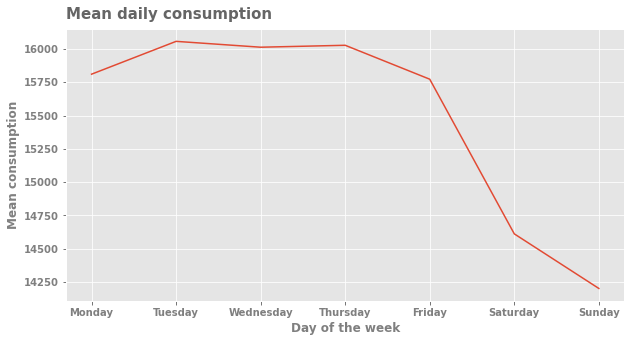

In [8]:
#Data prep
mean_per_day = df.groupby("Day")["AEP_MW"].agg(["mean"])

#Plot
fig, ax = plt.subplots(figsize=(10,5))


plt.plot(mean_per_day.index,mean_per_day["mean"])

plt.xticks(mean_per_day.index, ["Monday","Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"], alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Day of the week",alpha=0.75, weight="bold")
plt.ylabel("Mean consumption",alpha=0.75, weight="bold")

plt.title("Mean daily consumption", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10)

#del mean_per_day

The plot above showcases the cumulative consumption per day. We can very clearly see that days matter when it comes to consumption. The lowest usage is usually marked on the weekends as most commercial and industrial areas stay closed reducing the overall consumption of the area.

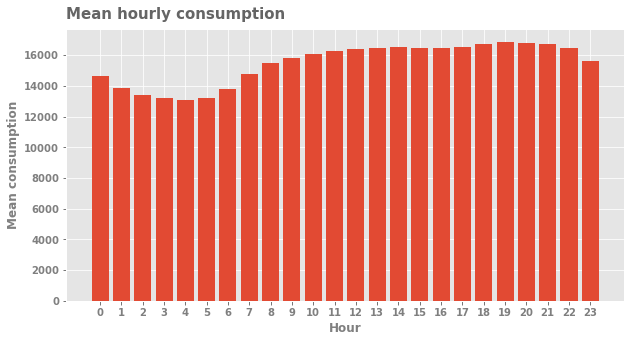

In [9]:
#Data
mean_per_hour = df.groupby("Hour")["AEP_MW"].agg(["mean"])

#Plot
fig, ax = plt.subplots(figsize=(10,5))

plt.bar(mean_per_hour.index, mean_per_hour["mean"])

plt.xticks(range(24),alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Hour",alpha=0.75, weight="bold")
plt.ylabel("Mean consumption",alpha=0.75, weight="bold")

plt.title("Mean hourly consumption", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10)

del mean_per_hour

Looking at hourly consumption we can clearly see the peak and off-peak  hours of the area.

Text(0.0, 1.0, 'Consumption over time')

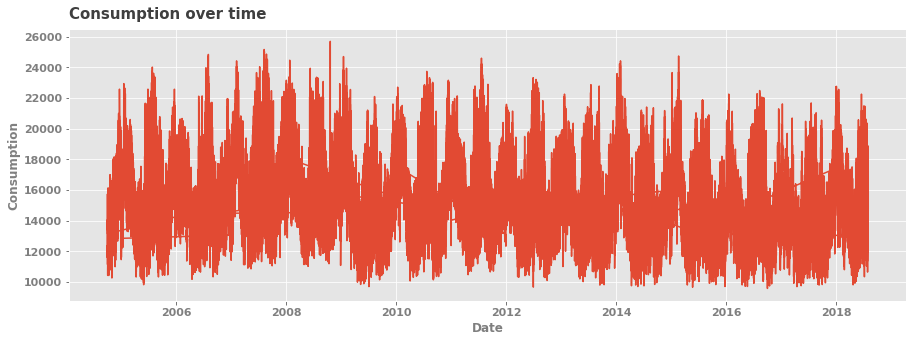

In [10]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(df.index,df["AEP_MW"])

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Consumption over time", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

    Looking at the consumption data as a whole we can very clearly see a pattern with peaks and valleys. While the baseline consumption stayed pretty much the sam on around 20.000. 

**Feature engineering - Part I**

During the second part, we will add columns that will help train the model and help it predict future consumption.

The categorical features added are:

1.	Holidays - I included some more famous American holidays.
2.	Worktime - If the half-hourly consumption demand happened during the usual worktime of most companies.
3. 	Peak/Off-Peak - I diverted this feature from the EDA above.
4.	Weekend/NonWeekend - If the day is a working day or not. I am aware that this might be duplicating information as we have other columns that that indicate the exact day, but I would nonetheless like to cover all my bases.

The numerical features:

1. Lag Variables - a shift in the data. I will explain more about this when we reach the cell.
2. Temperature data (not included) - I initially wanted to include the average temperature for each day. Unfortunately,  this is an RTO and as the name implies it covers multiple regions/states so getting and implementing good data was too difficult for now.



In [11]:
#Be ready for some bruteforce if functions
def feature_holidays(row):

    if row["Drop_me"] == "01-01":
        return "New Year"
    if row["Drop_me"] == "04-07":
        return "Ind Day"
    if row["Drop_me"] == "11-28":
        return "Thanksgiving"
    if row["Drop_me"] == "12-25":
        return "Christmas"
    return 'Other'
def feature_worktime(row):
    if row["Hour"] > 7 & row["Hour"] <= 17:
        return "Worktime"
    return "NonWorkTime"
def feature_peak(row):
    if row["Hour"] > 7 & row["Hour"] <= 22:
        return "Peak"
    return "NonPeak"
def feature_weekend(row):
    if row["Day"] == 5 or row["Day"] == 6:
        return "Weekend"
    return "NonWeekend"

In [12]:
df["Holiday"] = df.apply (lambda row : feature_holidays(row), axis=1)
df["Work"] = df.apply(lambda row: feature_worktime(row), axis=1)
df["Peak"] = df.apply(lambda row: feature_peak(row), axis=1)
df["Weekend"] = df.apply(lambda row: feature_weekend(row), axis=1)

In [13]:
df = df.drop(["Drop_me"],axis=1)

In [14]:
dummies = pd.get_dummies(df[["Holiday","Peak","Work","Weekend"]],prefix="Dummy")
df = df.join(dummies,lsuffix="_left")
df = df.drop(df[["Holiday","Peak","Work","Weekend"]], axis=1)

Below we are separating the dataset based on a date.

In [15]:
train_test_date = "01-01-2015"
consum_test = df[df.index > train_test_date].copy()
consum_train = df[df.index <= train_test_date].copy()

Lag variables are a classic approach to solving supervised regression problems on a time series dataset. The logic behind it is very simple, it uses the last variable to predict the next one. This adds additional features to the dataset and is usually very helpful.

There is, unfortunately, a downside to using Lag variables. They produce some NA values in the columns where the data is not available forcing us to drop them. This can severely reduce the number of rows we have for the training and testing of the algorithm. 

In [16]:
def lag_features(lag_dataset,period_list):

    temp_data = lag_dataset["AEP_MW"]

    for period in period_list:

        lag_dataset["lag_consumption_{}".format(period)] = temp_data.shift(period)
        lag_dataset["mean_rolling_{}".format(period)] = temp_data.rolling(period).mean()
        lag_dataset["max_rolling_{}".format(period)] = temp_data.rolling(period).max()
        lag_dataset["min_rolling_{}".format(period)] = temp_data.rolling(period).min()

    for column in lag_dataset.columns[20:]:

        lag_dataset[column] = lag_dataset[column].fillna(lag_dataset.groupby("Hour")["AEP_MW"].transform("mean"))
    
    return lag_dataset

In [17]:
consum_train = lag_features(consum_train,[7,14,30])

consum_test = lag_features(consum_test,[7,14,30])

Text(0.0, 1.0, 'Train - Test Split')

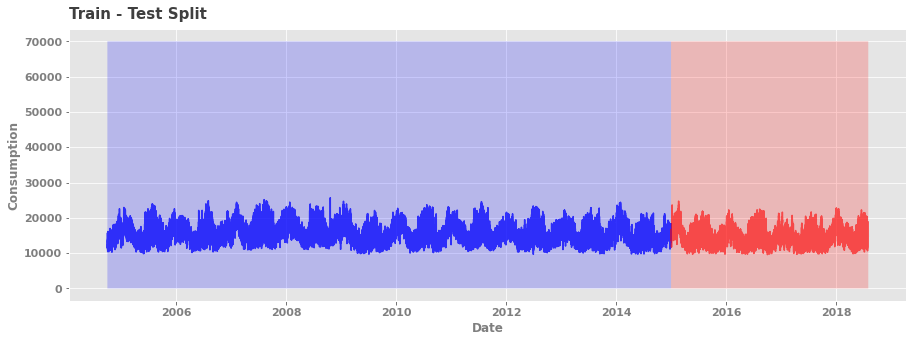

In [18]:
fig,ax = plt.subplots(figsize=(15,5))

coloring = 70000

plt.plot(consum_train.index,consum_train["AEP_MW"],color="blue", alpha=0.75)
plt.fill_between(consum_train.index,coloring, facecolor="blue", alpha=0.2)

plt.plot(consum_test.index,consum_test["AEP_MW"], color = "red", alpha=0.60)
plt.fill_between(consum_test.index,coloring, facecolor="red", alpha=0.2)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Train - Test Split", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

In [19]:
#Train - Test
X_train = consum_train.drop("AEP_MW", axis=1) 
y_train = consum_train["AEP_MW"]
X_test = consum_test.drop("AEP_MW", axis=1)
y_test = consum_test["AEP_MW"]

In [20]:
#XGBoost -- for feature selection --> this helps us tpo know the most important features that can be used to predict our required data
 
#Early stopping is a technique used to stop training when the loss on validation dataset starts increase (in the case of minimizing the loss). That’s why to train a model (any model, not only Xgboost) you need two separate datasets: training data for model fitting,  validation data for loss monitoring and early stopping.
xgd_reg = xgb.XGBRegressor(n_estimators=1000)

xgd_reg.fit(X_train,y_train,
           eval_set=[(X_train,y_train),(X_test,y_test)],
           early_stopping_rounds=50,
           verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

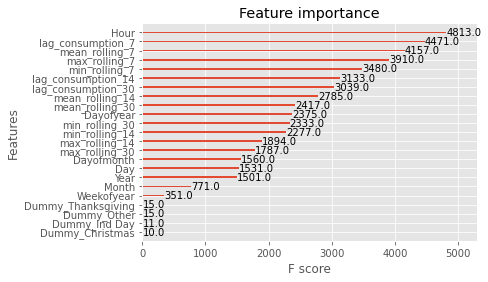

In [21]:
plot_importance(xgd_reg)

The plot importance option of XGBoost allows us to evaluate what features are good if we would like to use this algorithm in an automated pipeline or for any future use. In this instance, the F-score represents a simple metric that measures how many times the feature was used during the tree splitting.

In [22]:
consum_test["Prediction"] = xgd_reg.predict(X_test)

Text(0.0, 1.0, 'Predicted consumption')

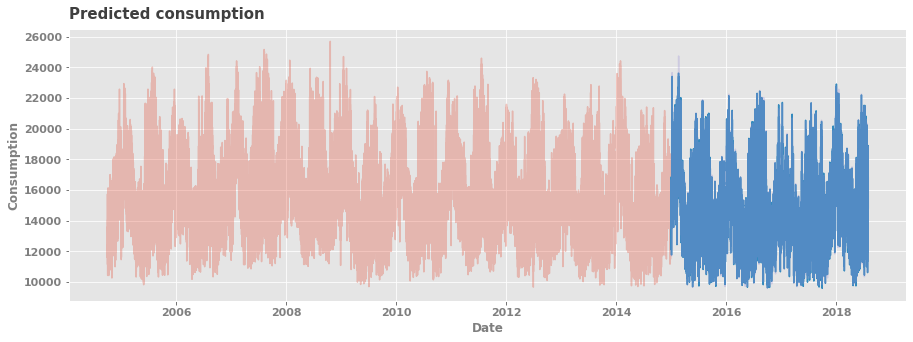

In [23]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(consum_train.index,consum_train["AEP_MW"],alpha=.3)
plt.plot(consum_test.index,consum_test["Prediction"])
plt.plot(consum_test.index,consum_test["AEP_MW"],alpha=.3)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Predicted consumption", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

The predicted value covers most of the actual value on the plot. This can either be very good or very bad. We need to inquire further.

Text(0.0, 1.0, 'Predicted consumption')

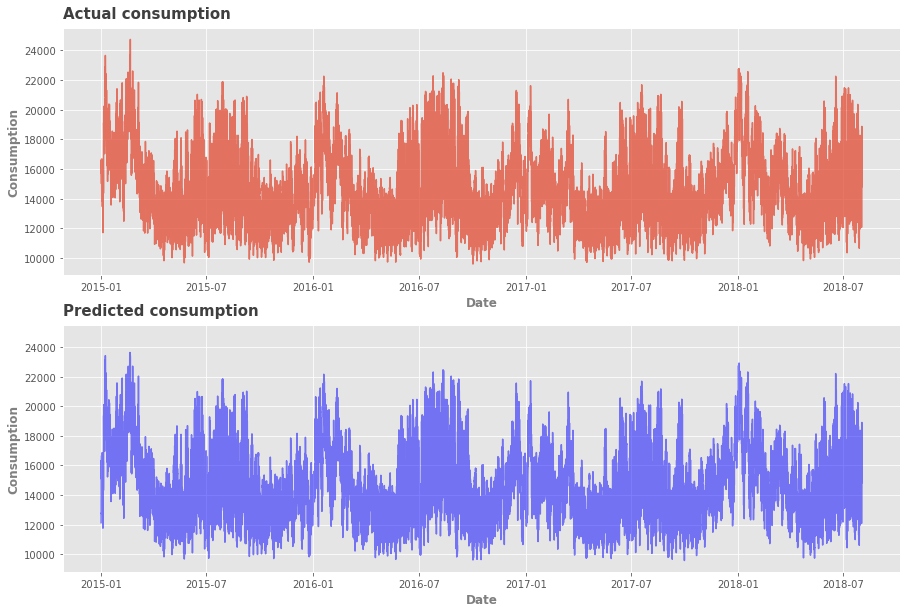

In [24]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(15,10),sharey=True)

ax1.plot(consum_test.index,consum_test["AEP_MW"],alpha=0.75)
ax2.plot(consum_test.index,consum_test["Prediction"],color="blue",alpha=0.50)

ax1.set_xlabel("Date", alpha=0.75, weight="bold")
ax1.set_ylabel("Consumption", alpha=0.75, weight="bold")
ax2.set_xlabel("Date", alpha=0.75, weight="bold")
ax2.set_ylabel("Consumption", alpha=0.75, weight="bold")

ax1.set_title("Actual consumption", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")
ax2.set_title("Predicted consumption", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

The actual consumption is again covered by the predicted consumption. We have to resort to evaluation metrics.

In [25]:
mean_sq = mean_squared_error(y_test,xgd_reg.predict(X_test))
rmse = np.sqrt(mean_sq)

mean_abs_sq = mean_absolute_error(y_test,xgd_reg.predict(X_test))

print("Root Mean Squared Error : {}".format(rmse))
print("Mean Absolute Error : {}".format(mean_abs_sq))

Root Mean Squared Error : 200.55323271920267
Mean Absolute Error : 125.86287879258427


In [26]:
# Worst Hour Prediction
consum_test["Difference"] = np.abs(consum_test["AEP_MW"] - consum_test["Prediction"])
consum_test["Difference"].sort_values(ascending=False)[:10]

Datetime
2015-01-01 01:00:00    4037.453125
2015-01-01 02:00:00    3728.327148
2015-01-01 04:00:00    3083.703125
2015-01-01 03:00:00    2962.118164
2015-01-01 05:00:00    2961.739258
2015-12-27 15:00:00    2512.455078
2015-12-27 16:00:00    2452.608398
2015-12-27 17:00:00    2316.068359
2015-01-01 06:00:00    2098.106445
2015-12-27 18:00:00    2015.918945
Name: Difference, dtype: float64

In [27]:
#Worst Days
worst_days = consum_test.groupby(['Year','Month','Dayofmonth']).mean()[['AEP_MW','Prediction','Difference']]
worst_days.sort_values(by="Difference",ascending=False)[:10]

AEP_MW    Prediction   Difference
Year Month Dayofmonth                                         
2015 1     1           15968.304348  15101.922852  1051.213612
     12    27          11998.916667  12456.409180   674.673706
     2     16          21129.791667  20849.941406   478.624186
     11    26          11718.500000  12042.923828   433.229533
     2     20          22047.041667  21857.453125   419.063883
2017 12    31          18381.750000  17990.632812   391.117920
2018 1     6           20847.833333  20499.000000   379.982422
2015 12    25          11078.041667  11387.554688   339.272502
2018 1     4           20473.375000  20141.017578   338.768962
2015 3     7           16496.625000  16638.328125   338.078328

In [28]:
#Best Days
worst_days.sort_values(by="Difference",ascending=True)[:20]

AEP_MW    Prediction  Difference
Year Month Dayofmonth                                        
2017 9     19          14840.375000  14833.879883   28.816203
2018 8     3           14809.000000  14842.855469   33.855469
2017 6     1           13882.791667  13893.083008   34.092326
           17          15586.416667  15577.466797   38.480550
2018 6     15          15586.083333  15584.796875   40.323649
2017 8     7           14179.583333  14191.503906   42.393026
2018 5     18          13684.333333  13669.636719   43.739217
2015 6     4           14515.958333  14513.909180   44.587118
2016 9     29          13279.666667  13275.898438   44.801839
2017 8     12          14101.500000  14113.384766   45.043091
     9     14          13743.333333  13713.123047   45.146973
2016 9     30          13066.291667  13078.501953   45.575114
2017 5     18          15567.333333  15600.430664   45.635050
2016 5     25          14179.625000  14177.959961   46.172201
2017 8     6           12405.708333  12390.976562   46.950114
           14          15433.958333  15438.085938   47.194132
2015 10    13          13201.708333  13207.153320   47.213216
     8     12          15202.458333  15204.528320   47.856405
2017 6     9           13821.625000  13813.769531   48.812988
     5     25          13150.750000  13153.905273   48.857992

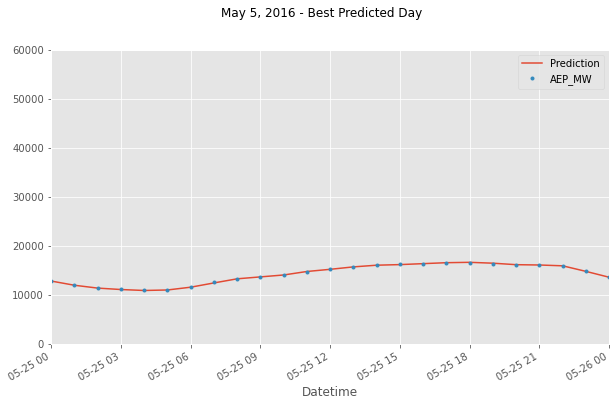

In [52]:
pjme_all = pd.concat([consum_test, consum_train], sort=True)


f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(10)
_ = pjme_all[['Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='05-25-2016', upper='05-26-2016')
plot = plt.suptitle('May 5, 2016 - Best Predicted Day')